In [23]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
import torch.nn.functional as F  # импортируем все библиотеки
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
from torch import nn, optim, tensor, Tensor
from IPython.display import clear_output
from tqdm import tqdm
import torchvision
from torchsummary import summary
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Metric
from sklearn.metrics import f1_score

In [25]:
class Xray_Mask_Dataloader(Dataset):
    def __init__(self, root_dir='yandex_ml_lunge/data'):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'train_images')
        self.label_dir = os.path.join(root_dir, 'train_lung_masks')

        self.image_list = os.listdir(self.image_dir)
        self.transform = transforms.Compose([
            PILToTensor(),
            ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, f'img_{idx}.png')
        image = Image.open(img_name)
        image = self.transform(image)
        image = torch.cat([image, image, image], dim=0)

        label_name = os.path.join(self.label_dir, f'img_{idx}.png')
        label = Image.open(label_name)
        label = self.transform(label)

        return image.to(device), label.to(device)

In [26]:
class CropByMask(object):
    def __init__(self):
        pass

    def __call__(self, img, mask):
        img_np = np.array(img)
        mask_np = np.array(mask)
        img_cropped = np.where(mask_np == 1, img_np * 1.3, img_np * 0.7)
        img_cropped = torch.Tensor(img_cropped).view(1, 256, 256)
        return img_cropped

In [27]:
class Mask_Conclusion_Dataloader(Dataset):
    def __init__(self, root_dir='yandex_ml_lunge/data', image_dir='train_images', mask_dir='train_lung_masks', target_path='train_answers.csv'):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, image_dir)
        self.mask_dir = os.path.join(root_dir, mask_dir)
        self.target_dir = os.path.join(root_dir, target_path)

        self.image_list = os.listdir(self.image_dir)

        self.cropper = CropByMask()

        self.transform = transforms.Compose([
            PILToTensor(),
            ToDtype(torch.float32, scale=True),
        ])

        self.augment_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5), 
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1)),
            transforms.ToTensor()
        ])

        self.targets = torch.Tensor(pd.read_csv(self.target_dir)['target_feature'].values)


    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, f'img_{idx}.png')
        image = Image.open(img_name)
        image = self.transform(image)

        mask_name = os.path.join(self.mask_dir, f'img_{idx}.png')
        mask = Image.open(mask_name)
        mask = self.transform(mask)
        image = self.cropper(image, mask)
        image = self.augment_transform(image)
        image = torch.cat([image, image, image], dim=0)

        label = [0, 0, 0]
        label[int(self.targets[idx])] = 1
        label = Tensor(label)

        
        return image.to(device), label.to(device)

In [28]:
xray_mask_dataset = Xray_Mask_Dataloader()
mask_train_set, mask_valid_set = random_split(xray_mask_dataset, (0.95, 0.05))

mask_conclusion_dataset = Mask_Conclusion_Dataloader()
conclusion_train_set, conclusion_valid_set = random_split(mask_conclusion_dataset, (0.95, 0.05))

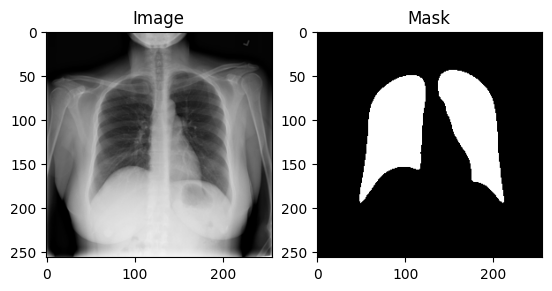

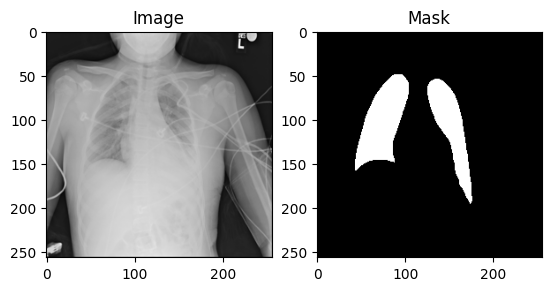

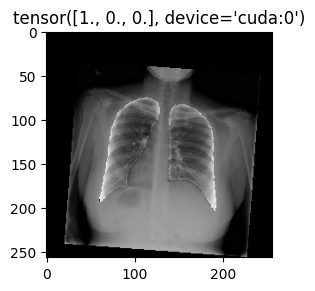

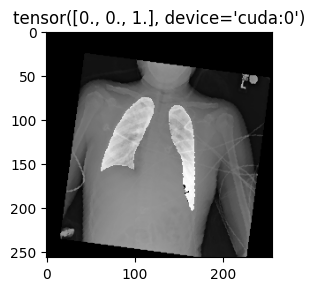

In [29]:
import matplotlib.pyplot as plt

data_labels = {2: 'covid_19', 1: 'non_covid', 0: 'normal'}

for i in range(2):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(xray_mask_dataset[i][0].permute(1, 2, 0).cpu(), cmap='gray')
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(xray_mask_dataset[i][1].permute(1, 2, 0).cpu(), cmap='gray')
    plt.title('Mask')

    plt.show()

for i in range(2):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(mask_conclusion_dataset[i][0].permute(1, 2, 0).cpu(), cmap='gray')
    plt.title(f'{mask_conclusion_dataset[i][1]}')

    plt.show()

In [30]:
from IPython.display import clear_output
import numpy as np

def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

In [33]:
class F1(nn.Module):
    def __init__(self):
        super(F1, self).__init__()

    def forward(self, inputs, targets, smooth=1):     

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        precision_recall = (inputs * targets).sum()                            
        f1 = (2.*precision_recall + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return f1


class F1CELoss(nn.Module):
    def __init__(self):
        super(F1CELoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, inputs, targets, smooth=1):     

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        precision_recall = (inputs * targets).sum()                            
        f1_loss = 1 - (2.*precision_recall + smooth) / (inputs.sum() + targets.sum() + smooth)  
        ce_loss = self.cross_entropy(inputs, targets)

        return f1_loss + ce_loss / 20

In [34]:
Seq = nn.Sequential(
    nn.Conv2d(3, 128, 5),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(128, 256, 5),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(256, 512, 5),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(512, 512, 5),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(512 * 12 * 12, 64),
    nn.ReLU(),
    nn.Linear(64, 3),
    nn.Softmax(dim=1)
)

In [36]:
model = Seq.to(device)

In [37]:
print(summary(model, (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 252, 252]           9,728
       BatchNorm2d-2        [-1, 128, 252, 252]             256
              ReLU-3        [-1, 128, 252, 252]               0
         MaxPool2d-4        [-1, 128, 126, 126]               0
            Conv2d-5        [-1, 256, 122, 122]         819,456
       BatchNorm2d-6        [-1, 256, 122, 122]             512
              ReLU-7        [-1, 256, 122, 122]               0
         MaxPool2d-8          [-1, 256, 61, 61]               0
            Conv2d-9          [-1, 512, 57, 57]       3,277,312
      BatchNorm2d-10          [-1, 512, 57, 57]           1,024
             ReLU-11          [-1, 512, 57, 57]               0
        MaxPool2d-12          [-1, 512, 28, 28]               0
           Conv2d-13          [-1, 512, 24, 24]       6,554,112
      BatchNorm2d-14          [-1, 512,

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
metrics = {
    "loss": Loss(nn.BCELoss()),
    'f1': Loss(F1())
}

In [39]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
train_evaluator = create_supervised_evaluator(model, metrics=metrics)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics)

train_loader = DataLoader(conclusion_train_set, batch_size=8)
valid_loader = DataLoader(conclusion_valid_set, batch_size=8)

In [40]:
from ignite.engine import Events, Engine

PATH = 'class_model.pth'
train_loss_hist = []
test_loss_hist = []

def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output}")

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=10), log_iter_loss)

def compute_epoch_results(engine: Engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

def log_epoch_results(engine: Engine, label="", is_train=True):
    if is_train:
        train_loss_hist.append(engine.state.metrics['loss'])
    else:
        if test_loss_hist == [] or engine.state.metrics['loss'] < min(test_loss_hist):
            torch.save(model, PATH)
        test_loss_hist.append(engine.state.metrics['loss'])
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label} Res:", result)

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train", is_train=True)
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid", is_train=False)

In [41]:
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)

In [42]:
trainer.run(train_loader, 30)

Epoch[1] - Iter[10]: loss = 0.7869402766227722
Epoch[1] - Iter[20]: loss = 0.8497010469436646
Epoch[1] - Iter[30]: loss = 0.6344707012176514
Epoch[1] - Iter[40]: loss = 0.6751327514648438
Epoch[1] - Iter[50]: loss = 0.5022444725036621
Epoch[1] - Iter[60]: loss = 0.8651899099349976
Epoch[1] - Iter[70]: loss = 0.6427540183067322
Epoch[1] - Iter[80]: loss = 0.6406688690185547
Epoch[1] - Iter[90]: loss = 0.2756422758102417
Epoch[1] - Iter[100]: loss = 0.6843509674072266
Epoch[1] - Iter[110]: loss = 0.8697220683097839
Epoch[1] - Iter[120]: loss = 0.5437599420547485
Epoch[1] - Iter[130]: loss = 0.5342767238616943
Epoch[1] - Iter[140]: loss = 0.7492938041687012
Epoch[1] - Iter[150]: loss = 0.5799076557159424
Epoch[1] - Iter[160]: loss = 0.5666195154190063
Epoch[1] - Iter[170]: loss = 0.5271902680397034
Epoch[1] - Iter[180]: loss = 0.412608802318573
Epoch[1] - Iter[190]: loss = 0.7660025954246521
Epoch[1] - Iter[200]: loss = 0.6007539629936218
Epoch[1] - Iter[210]: loss = 0.6903743147850037
Ep

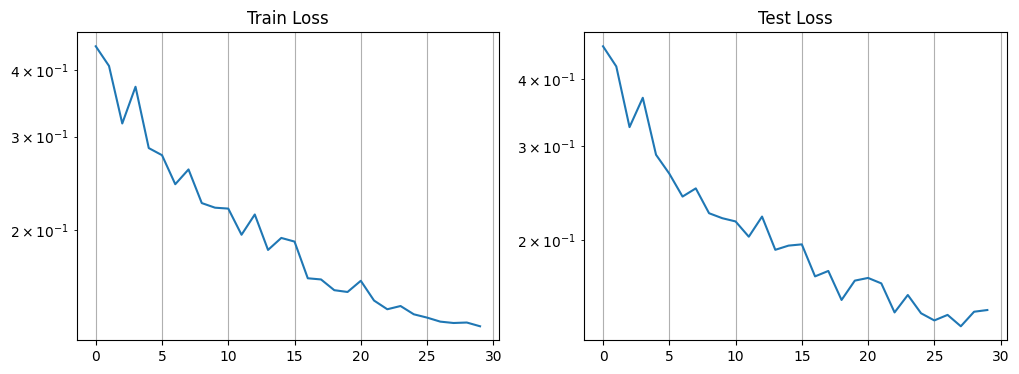

Min train loss: 0.13195893107334308
Min test loss: 0.1380263830114294


In [43]:
show_losses(train_loss_hist, test_loss_hist)
print(f'Min train loss: {min(train_loss_hist)}\nMin test loss: {min(test_loss_hist)}')